In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import numpy as np

In [2]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
train_demo = pd.read_csv("data/train_demographics.csv")
test_demo = pd.read_csv("data/test_demographics.csv")

In [3]:
print("Train shape:", train.shape)
print("Test shape:", test.shape)
print("Train demo shape:", train_demo.shape)
print("Test demo shape:", test_demo.shape)


Train shape: (574945, 341)
Test shape: (107, 336)
Train demo shape: (81, 8)
Test demo shape: (2, 8)


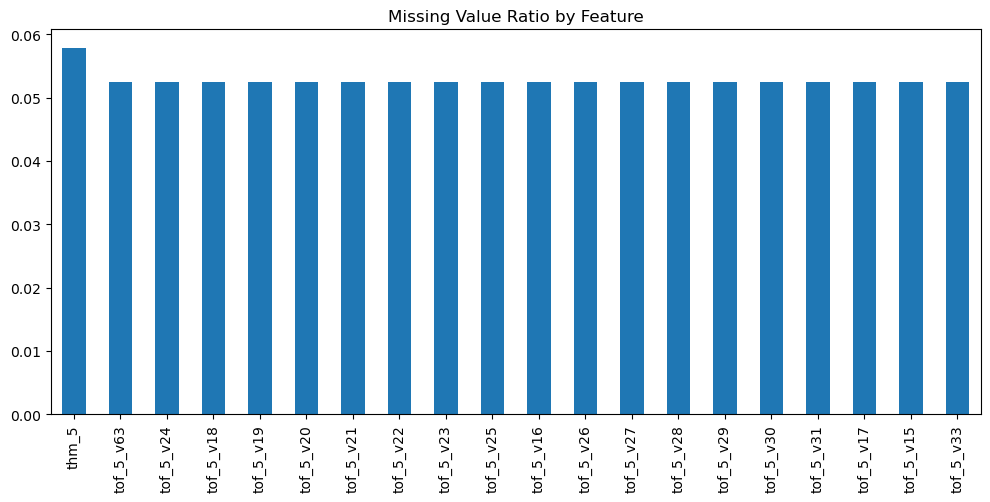

In [5]:
# Check missingness for representative columns
missing_cols = train.columns[train.isnull().any()]
missing_summary = train[missing_cols].isnull().mean().sort_values(ascending=False)
# sns.barplot(missing_summary.head(20))
missing_summary.head(20).plot.bar(figsize=(12, 5), title="Missing Value Ratio by Feature");

In [8]:
gesture_counts = train[['gesture', 'sequence_type']].value_counts()
# gesture_counts.plot(kind="bar", title="Distribution of Gestures")

In [14]:
gesture_counts = gesture_counts.reset_index()

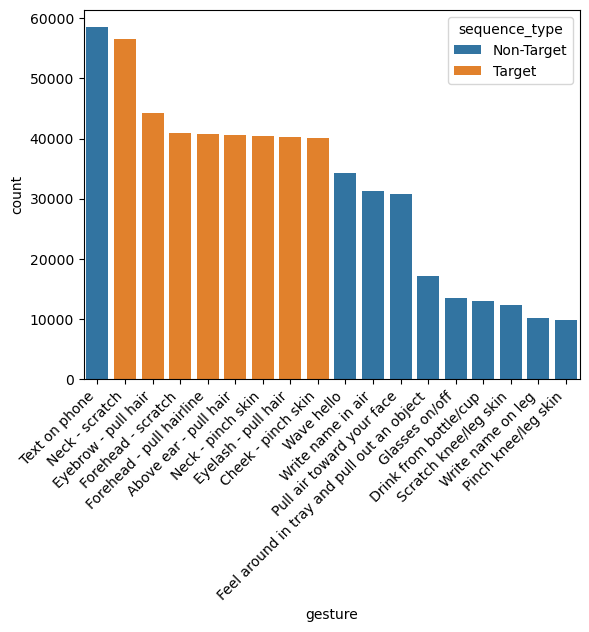

In [30]:
ax = sns.barplot(gesture_counts, x='gesture', y='count', hue='sequence_type')
labels = ax.get_xticklabels()
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(labels, rotation=45, ha='right');

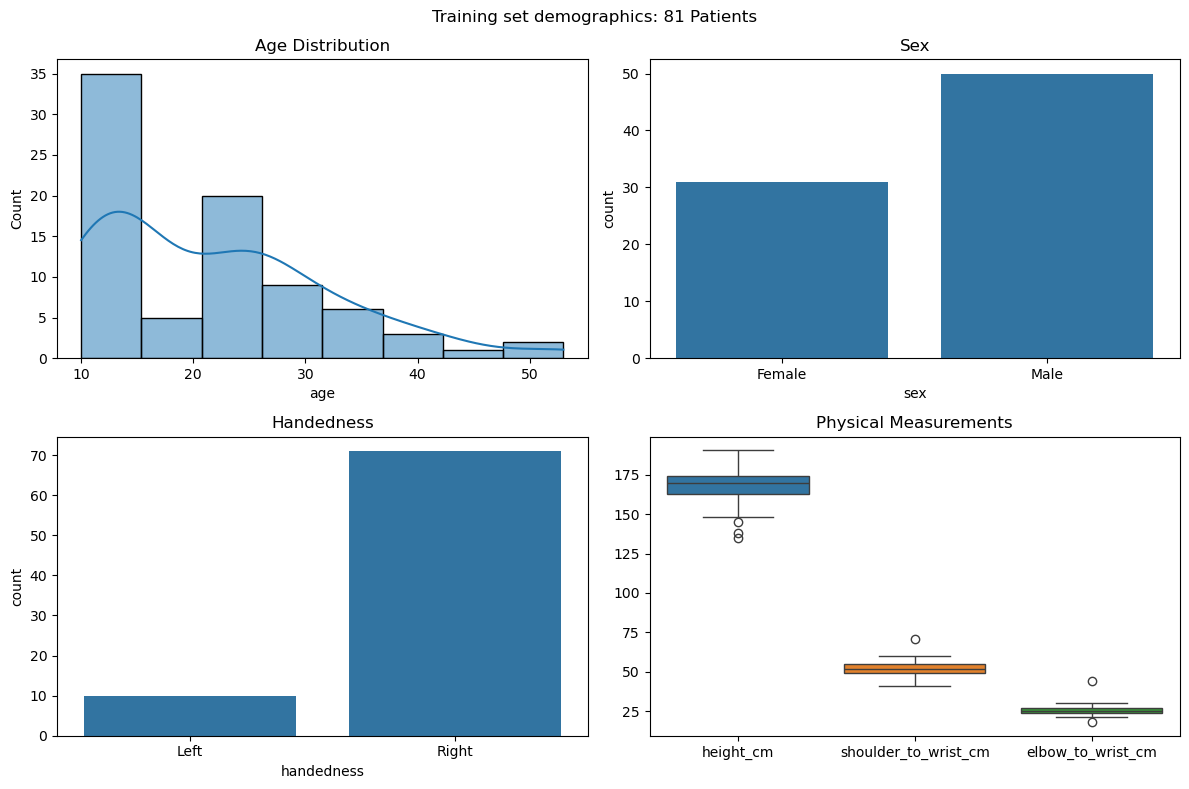

In [31]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

sns.histplot(train_demo['age'], kde=True, ax=axs[0, 0])
axs[0, 0].set_title("Age Distribution")

ax = sns.countplot(x='sex', data=train_demo, ax=axs[0, 1])
ax.set_xticks(ax.get_xticks(), labels=['Female', 'Male'])
ax.set_title("Sex")

ax = sns.countplot(x='handedness', data=train_demo, ax=axs[1, 0])
ax.set_xticks(ax.get_xticks(), labels=['Left', 'Right'])
ax.set_title("Handedness")

sns.boxplot(data=train_demo[['height_cm', 'shoulder_to_wrist_cm', 'elbow_to_wrist_cm']], ax=axs[1, 1])
axs[1, 1].set_title("Physical Measurements")

fig.suptitle(f'Training set demographics: {train_demo["subject"].nunique()} Patients')
fig.tight_layout();

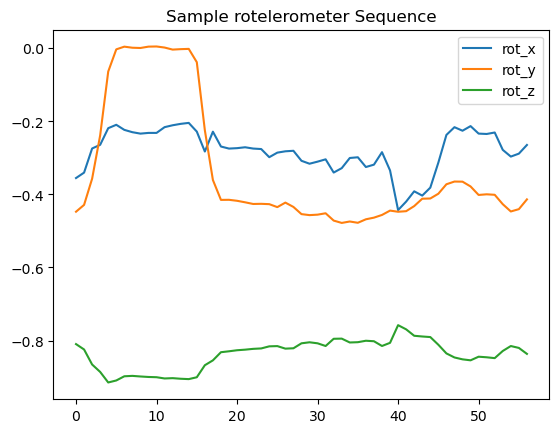

In [9]:
sample_seq = train[train['sequence_id'] == train['sequence_id'].iloc[0]]
plt.plot(sample_seq['sequence_counter'], sample_seq['rot_x'], label='rot_x')
plt.plot(sample_seq['sequence_counter'], sample_seq['rot_y'], label='rot_y')
plt.plot(sample_seq['sequence_counter'], sample_seq['rot_z'], label='rot_z')
plt.title("Sample rotelerometer Sequence")
plt.legend()

Text(0.5, 1.0, 'Thermopile Readings')

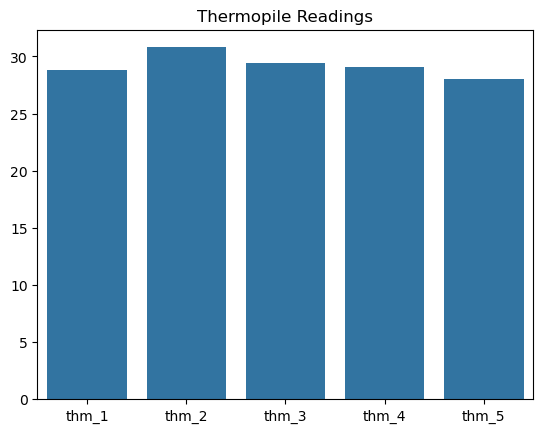

In [10]:
# Thermopile example
thermo_cols = [f'thm_{i}' for i in range(1, 6)]
thermo_vals = sample_seq[thermo_cols].iloc[-1]  # Last Gesture frame
sns.barplot(x=thermo_cols, y=thermo_vals.values)
plt.title("Thermopile Readings")

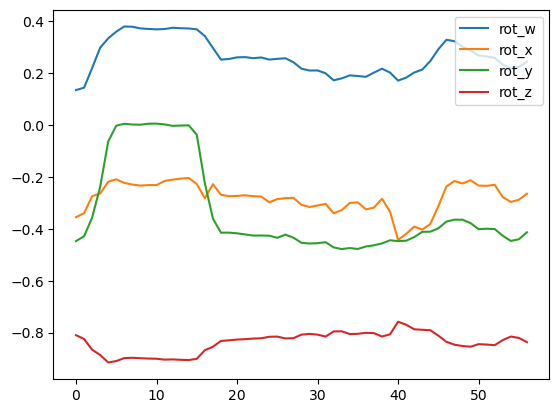

In [11]:
sample_seq = train[train['sequence_id'] == train['sequence_id'].iloc[0]]
plt.plot(sample_seq['sequence_counter'], sample_seq['rot_w'], label='rot_w')
plt.plot(sample_seq['sequence_counter'], sample_seq['rot_x'], label='rot_x')
plt.plot(sample_seq['sequence_counter'], sample_seq['rot_y'], label='rot_y')
plt.plot(sample_seq['sequence_counter'], sample_seq['rot_z'], label='rot_z')
# plt.title("Sample ÷elerometer Sequence")
plt.legend()

# rot_cols = [f'rot_{i}' for i in ['w', 'x', 'y', 'z']]
# rot_vals = sample_seq[rot_cols].iloc[-1]  # Last Gesture frame
# sns.barplot(x=thermo_cols, y=thermo_vals.values)
# plt.title("Thermopile Readings")

In [32]:
def extract_features(df):
    features = []

    for seq_id, group in df.groupby('sequence_id'):
        feats = {'sequence_id': seq_id}

        # Accelerometer features
        for axis in ['acc_x', 'acc_y', 'acc_z']:
            feats[f'{axis}_mean'] = group[axis].mean()
            feats[f'{axis}_std'] = group[axis].std()
            feats[f'{axis}_max'] = group[axis].max()
            feats[f'{axis}_min'] = group[axis].min()

        # Thermopile sensors
        for i in range(1, 6):
            col = f'thm_{i}'
            feats[f'{col}_mean'] = group[col].mean()
            feats[f'{col}_std'] = group[col].std()

        # ToF: Count close pixels & missing data
        for s in range(1, 6):
            tof_cols = [f'tof_{s}_v{v}' for v in range(64)]
            vals = group[tof_cols].values
            close_mask = (vals >= 0) & (vals < 50)
            feats[f'tof_{s}_close_frac'] = np.mean(close_mask)
            feats[f'tof_{s}_missing_frac'] = np.mean(vals == -1)

        features.append(feats)

    return pd.DataFrame(features)




In [61]:
features = extract_features(train)
labels = train.groupby('sequence_id').first()[['gesture', 'sequence_type', 'subject', 'orientation']].reset_index()
train_df = features.merge(labels, on='sequence_id')
train_df = train_df.merge(train_demo, on='subject')

In [62]:
X = train_df.drop(columns=['sequence_id', 'gesture', 'sequence_type', 'subject', 'orientation'])
y = train_df['sequence_type'].map({'Target': 1, 'Non-Target': 0})

In [43]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# X = train_df.drop(columns=['sequence_id', 'gesture', 'sequence_type'])
# y = train_df['sequence_type'].map({'Target': 1, 'Non-Target': 0})  # Binary target

X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

binary_model = LGBMClassifier(n_estimators=100, random_state=42)
binary_model.fit(X_train, y_train)

y_pred = binary_model.predict(X_val)
print(classification_report(y_val, y_pred))

[LightGBM] [Info] Number of positive: 4090, number of negative: 2430
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000572 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8268
[LightGBM] [Info] Number of data points in the train set: 6520, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.627301 -> initscore=0.520654
[LightGBM] [Info] Start training from score 0.520654
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       608
           1       0.97      0.97      0.97      1023

    accuracy                           0.96      1631
   macro avg       0.96      0.96      0.96      1631
weighted avg       0.96      0.96      0.96      1631



## Multiclass


In [63]:
from sklearn.preprocessing import LabelEncoder

# You can decode predictions later using: le.inverse_transform(preds)
X = train_df.drop(columns=['sequence_id', 'gesture', 'sequence_type', 'subject', 'orientation' ])
y = train_df['orientation'] #.map({'target': 1, 'non-target': 0})  # Binary target

le = LabelEncoder()
y_encoded = le.fit_transform(y)  # LightGBM expects integer labels for multiclass

X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, stratify=y, test_size=0.2, random_state=42)


In [64]:
model = LGBMClassifier(
    objective='multiclass',
    num_class=len(le.classes_),  # important!
    n_estimators=100,
    random_state=42
)

model.fit(X_train, y_train)
y_pred_encoded = model.predict(X_val)
y_pred = le.inverse_transform(y_pred_encoded)
y_val_decoded = le.inverse_transform(y_val)
print(classification_report(y_val_decoded, y_pred))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8268
[LightGBM] [Info] Number of data points in the train set: 6520, number of used features: 39
[LightGBM] [Info] Start training from score -1.452224
[LightGBM] [Info] Start training from score -1.454849
[LightGBM] [Info] Start training from score -1.441794
[LightGBM] [Info] Start training from score -1.217354
                                 precision    recall  f1-score   support

                    Lie on Back       0.97      0.96      0.97       382
     Lie on Side - Non Dominant       0.93      0.95      0.94       381
Seated Lean Non Dom - FACE DOWN       0.95      0.94      0.95       386
                Seated Straight       0.95      0.95      0.95       482

                       accuracy                           0.95      1631
                      macro avg       0.95      0.95    

In [49]:
def plot_feature_importance(model, top_n=30, importance_type='gain'):
    importance = model.booster_.feature_importance(importance_type=importance_type)
    feature_names = model.booster_.feature_name()
    
    imp_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importance
    }).sort_values(by='importance', ascending=False).head(top_n)
    
    plt.figure(figsize=(10, 6))
    plt.barh(imp_df['feature'][::-1], imp_df['importance'][::-1])
    plt.title(f'Top {top_n} Feature Importances ({importance_type})')
    plt.xlabel(importance_type.capitalize())
    plt.tight_layout()
    plt.show()

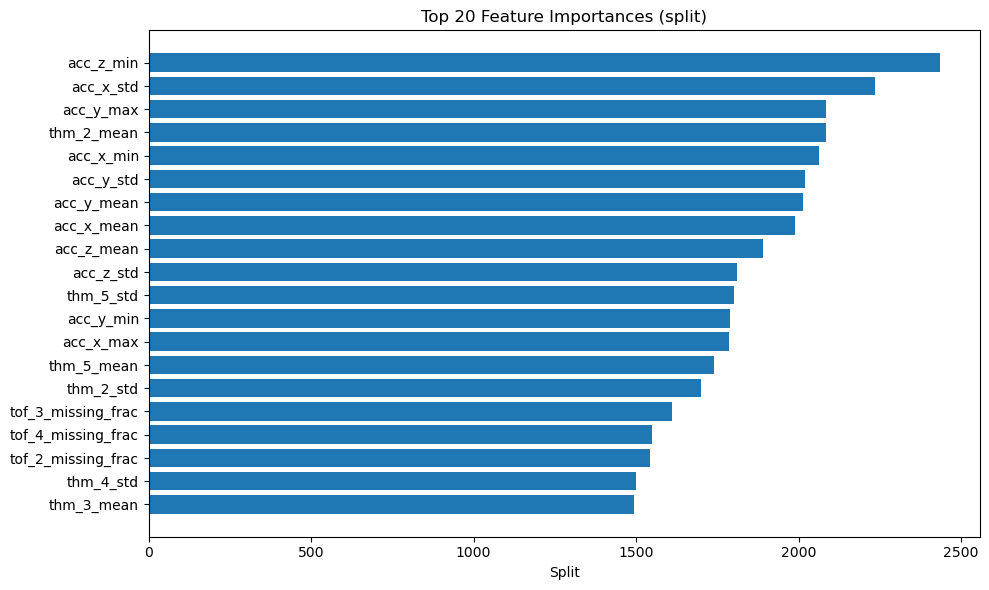

In [51]:
plot_feature_importance(model, top_n=20, importance_type='split')